**Exercise 1**

Tackle MNIST!

In [30]:
import numpy as np
import os
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import accuracy_score
from scipy.ndimage.interpolation import shift
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import expon, reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import tarfile
import urllib
import email
from email import policy
from collections import Counter

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape
np.max(X)

255.0

In [5]:
y.shape

(70000,)

In [6]:
np.count_nonzero(~np.isnan(X))

54880000

In [7]:
# Double check that there are no null values

70000*784 

54880000

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImageRegularizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_pixel_size):
        self.max_pixel_size = max_pixel_size
    def fit(self, X, y=None):
        return self # Nothing to do
    def transform(self, X):
        return X * (1/self.max_pixel_size)

In [9]:
reg = ImageRegularizer(np.max(X))
reg_X = reg.transform(X)

In [10]:
# Our pipeline consists only of normalizing our greyscale values

pipeline = Pipeline([
    ('regularizer', ImageRegularizer(max_pixel_size=np.max(X)))
])

In [11]:
reg_X = pipeline.transform(X)
np.max(reg_X)

1.0

In [12]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

In [13]:
clf = KNC(n_jobs=-1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = clf.predict(X_train)

In [ ]:
print(accuracy_score(y_train, y_pred))

**Exercise 2**

Write function to shift MNIST image in any direction, then apply it to dataset

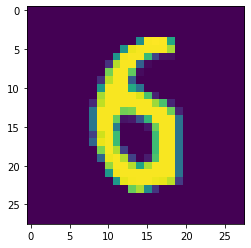

In [40]:
image = X_train[np.random.randint(0,60000)].reshape(28,28)
plt.imshow(image)

In [41]:
def shift_image(image, dx, dy):
    image = image.reshape(28,28) # Reshape to image format (incase not done already)
    return shift(image, (dx, dy)).reshape(-1)

(784,)
(784,)


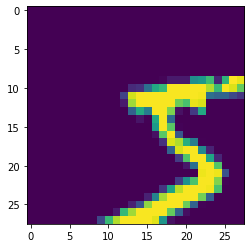

In [50]:
shifted_image = shift_image(image, 4, 5)
plt.imshow(shifted_image.reshape(28,28))
print(shifted_image.shape)
print(image.shape)

In [43]:
shifts = [(1,0), (-1,0), (0,1), (0,-1)]

In [54]:
X_train_augmented = [image for image in X_train] # Convert to list to effeciently append
y_train_augmented = [label for label in y_train] # Convert to list to effeciently append

for dx, dy in shifts:
    for image, label in zip(X_train_augmented, y_train):
        shifted_image = shift_image(image, dx, dy)
        X_train_augmented.append(shifted_image)
        y_train_augmented.append(label)

In [56]:
# Convert back to numpy array

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [57]:
X_train_augmented.shape

(300000, 784)

In [58]:
clf = KNC(n_jobs=-1)
clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_pred))

**Exercise 3**

Tackle the kaggle Titanic dataset

In [2]:
TITANIC_PATH = os.path.join('datasets', 'titanic')

In [3]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    df = pd.read_csv(csv_path)
    return df

In [4]:
train = load_titanic_data('train.csv')
test = load_titanic_data('test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note that we will have to deal with missing data in Age, Cabin, and Embarked

In [8]:
train_num = train[['Age', 'SibSp', 'Parch', 'Fare']]
train_cat = train[['Pclass', 'Sex', 'Embarked']]

In [9]:
train_num.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [10]:
train_cat.head()

,Pclass,Sex,Embarked
0,3,male,S
1,1,female,C
2,3,female,S
3,1,female,S
4,3,male,S


In [11]:
num_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy='median')),
    ('Scaler', StandardScaler())
])

In [12]:
train_num_tr = num_pipeline.fit_transform(train_num)
print(np.array(train_num_tr))

[[-0.56573646  0.43279337 -0.47367361 -0.50244517]
 [ 0.66386103  0.43279337 -0.47367361  0.78684529]
 [-0.25833709 -0.4745452  -0.47367361 -0.48885426]
 ...
 [-0.1046374   0.43279337  2.00893337 -0.17626324]
 [-0.25833709 -0.4745452  -0.47367361 -0.04438104]
 [ 0.20276197 -0.4745452  -0.47367361 -0.49237783]]


In [13]:
train_num.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [14]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoder', OneHotEncoder(sparse=False))
])

In [15]:
train_cat_tr = cat_pipeline.fit_transform(train_cat)

In [16]:
print(train_cat_tr)

[[0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


In [17]:
num_attribs = list(train_num)
cat_attribs = list(train_cat)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

train_prepared = full_pipeline.fit_transform(train)

In [18]:
train_prepared

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [19]:
y_train = train['Survived']

In [20]:
clf = KNC(n_jobs=-1)
clf.fit(train_prepared, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [21]:
clf.score(train_prepared, y_train)

0.8574635241301908

In [22]:
test_prepared = full_pipeline.fit_transform(test)

In [26]:
# Setup up randomized search for best params

param_distribs = {
    'kernel': ['rbf'],
    'C': reciprocal(20,200000),
    'gamma': expon(scale=1.0)
    
}

SVC_model = SVC()

rnd_search = RandomizedSearchCV(SVC_model, 
                           param_distributions=param_distribs, 
                           n_iter=30,
                           cv=5,
                           scoring='accuracy',
                           verbose=2, 
                           n_jobs=-1, 
                           )

rnd_search.fit(train_prepared, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DD8B4FCE08>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002DD8B4FA608>,
                                        'kernel': ['rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=2)

In [28]:
rnd_search.best_score_

0.8293955181721172

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_distribs = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rnd_search = RandomizedSearchCV(rf_model, 
                           param_distributions=param_distribs, 
                           n_iter=30,
                           cv=5,
                           scoring='accuracy',
                           verbose=2, 
                           n_jobs=-1, 
                           )

rnd_search.fit(train_prepared, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
rnd_search.best_score_

0.8328102441780176

In [37]:
final_model = rnd_search.best_estimator_

In [42]:
test_prepared = full_pipeline.fit_transform(test)

In [47]:
PassengerId = test['PassengerId']
predictions = np.c_[PassengerId, final_model.predict(test_prepared)]
submission = pd.DataFrame(predictions, columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = PassengerId
submission['Survived'] = final_model.predict(test_prepared)
submission.to_csv("rfSubmission.csv", index=False)

In [48]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
